## Homer CTP Prediction
Using consumer characteristics from trial period, predict whether customer will convert to paid at the end of their trial

In [340]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

dir(pd.options.display)
pd.options.display.max_columns = 50

In [341]:
homer = pd.read_csv('homer_clean.csv')

### 1. Data Exploration

In [342]:
homer.describe()

,userid,single_user,multiple_user,total_events,completed_count,not_completed_count,ipad_event,iphone_event,ipod_event,pathways_complete_rank,pathways_reach_rank,pathways_count,alc_count,average_age_int,first_week,second_week,third_week,distinct_weeks,distinct_days,avg_weekly_visit,avg_daily_hrs,max_days_into_trial,avg_days_from_trial,trial_day,max_stage_num,avg_level,avg_cluster,avg_step,distinct_titles,max_row,max_column,avg_row,avg_col,ctp
count,5.834000e+03,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5263.000000,5281.000000,5834.000000,5834.000000,5400.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5281.000000,5539.000000,5281.000000,5539.000000,5834.000000,3.466000e+03,3466.000000,3459.000000,3466.000000,5834.000000
mean,2.896520e+16,0.686664,0.313336,76.456462,50.795680,22.748543,33.600103,42.673294,0.183065,450.696561,460.993941,52.477374,23.979088,4.370926,0.984745,0.418581,0.344361,2.062393,4.841104,25.489201,1.847103,13.122043,4.936921,7.557079,3.294073,2.553349,1.047340,4.024553,33.741001,-1.862770e+16,11.369013,3.195721,3.241777,0.677580
std,5.349841e+18,0.463889,0.463889,129.560791,79.699731,58.472953,103.347261,94.666740,6.184218,284.176825,280.201537,77.953686,79.335395,1.742342,0.122578,0.493369,0.475200,1.115581,4.759494,29.341279,2.920150,11.508560,5.473731,3.996430,1.188351,1.352938,0.258992,1.921381,39.809618,4.141409e+17,13.144738,2.603580,3.185256,0.467443
min,-9.219518e+18,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-9.223372e+18,0.000000,0.000000,0.000000,0.000000
25%,-4.615946e+18,0.000000,0.000000,13.000000,8.000000,3.000000,0.000000,0.000000,0.000000,251.000000,251.000000,8.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,0.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,2.000000,9.000000,2.000000e+00,3.000000,1.000000,1.000000,0.000000
50%,-3.989598e+16,1.000000,0.000000,36.000000,25.000000,8.000000,0.000000,10.000000,0.000000,351.000000,361.000000,26.000000,2.000000,5.000000,1.000000,0.000000,0.000000,2.000000,3.000000,17.000000,0.000000,12.000000,3.000000,8.000000,3.000000,2.000000,1.000000,4.000000,20.000000,5.000000e+00,7.000000,2.000000,2.000000,1.000000
75%,4.680110e+18,1.000000,1.000000,91.000000,62.000000,22.000000,21.000000,46.000000,0.000000,601.000000,601.000000,66.000000,16.000000,6.000000,1.000000,1.000000,1.000000,3.000000,6.000000,32.000000,3.000000,25.000000,8.000000,11.000000,4.000000,3.000000,1.000000,5.000000,43.000000,1.300000e+01,18.000000,4.000000,4.000000,1.000000
max,9.221033e+18,1.000000,1.000000,3416.000000,1948.000000,1578.000000,3416.000000,2615.000000,425.000000,1563.000000,1563.000000,1258.000000,2540.000000,9.000000,1.000000,1.000000,1.000000,4.000000,32.000000,683.000000,23.000000,31.000000,30.000000,14.000000,5.000000,11.000000,4.000000,14.000000,398.000000,2.800000e+01,105.000000,27.000000,40.000000,1.000000


In [343]:
homer.head()

,userid,path_type,multi_user_label,single_user,multiple_user,total_events,completed_count,completed_cat,not_completed_count,event_count_cat,device_cat,ipad_event,iphone_event,ipod_event,max_stage_complete,pathways_complete_rank,pathways_reach_rank,pathways_count,alc_count,average_age_int,max_stage,first_week,second_week,third_week,distinct_weeks,distinct_days,avg_weekly_visit,avg_daily_hrs,weekly_visit_cat,max_days_into_trial,avg_days_from_trial,trial_day,max_stage_num,avg_level,avg_cluster,avg_step,pop_event_day,pop_title,pop_category,distinct_titles,title_count_cat,max_row,max_column,avg_row,avg_col,ctp
0,-9.219518e+18,"alc, pathways",Single-user,1,0,36,25,med,8,medium,iPhone,0,36,0,A,121.0,211.0,9,27,NaN,A,1,1,1,3,6,9,0,medium,21,16,14,1.0,1.0,1.0,1.0,Saturday,Letter Hunt,GAM,24,high,1.0,25.0,1.0,9.0,1
1,-9.218149e+18,pathways,Single-user,1,0,5,4,low,0,low,iPhone,0,5,0,A,121.0,211.0,5,0,1.0,A,1,0,1,2,2,3,0,low,20,4,1,1.0,1.0,1.0,1.0,Sunday,Letter Hunt,NaN,2,low,NaN,NaN,NaN,NaN,0
2,-9.217416e+18,"alc, pathways",Single-user,1,0,59,36,med,21,high,iPhone,0,59,0,C,511.0,521.0,40,19,4.0,C,1,0,0,1,2,30,0,high,5,3,8,3.0,3.0,1.0,6.0,Friday,"Make the Letters: A,a",NaN,39,high,20.0,16.0,3.0,4.0,0
3,-9.217257e+18,"alc, pathways",Single-user,1,0,126,111,very_high,14,very high,iPad,126,0,0,C,351.0,351.0,27,99,4.0,C,1,1,1,3,10,42,3,very high,16,10,5,3.0,2.0,1.0,6.0,Thursday,Swimmy,RAS,87,very high,21.0,15.0,4.0,4.0,1
4,-9.212743e+18,"alc, pathways",Multiple-user,0,1,144,105,very_high,35,very high,iPad,144,0,0,B,961.0,961.0,64,80,3.0,B,1,1,1,4,14,36,3,very high,22,7,9,2.0,5.0,1.0,4.0,Tuesday,The Airport,NaN,87,very high,28.0,16.0,2.0,3.0,1


In [344]:
#benchmarks:
baseline = homer['ctp'].value_counts()[1]/homer['ctp'].value_counts().sum()
print(f'baseline conversion is {baseline}')
print('distinct users is {}'.format(homer['userid'].nunique()))

baseline conversion is 0.6775797051765513
distinct users is 5834


In [345]:
def conversion_calc(df, column, plot = True):
    if plot:
        plt.rcParams['figure.figsize'] = (7,45)
        figure, axes = plt.subplots(len(categorical_columns))
    for i in range(0, len(categorical_columns)):
        category = column[i]
        grouped = df.groupby([category,'ctp'])[['ctp']].count().rename(columns={'ctp':'count'}).reset_index()
        grouped['total']=[grouped[grouped[category]==element]['count'].sum() for element in grouped[category]]
        grouped['conversion'] = grouped['count']/grouped['total']
        if plot:
            mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
            sns.barplot(grouped[category], grouped['conversion'], hue = grouped['ctp'], ax = axes[i], palette = mypalette)
            axes[i].title.set_text(column[i])
            axes[i].set_xlabel('')
            figure.subplots_adjust(hspace = 0.37)
        else:
            return grouped

def plot_continuous(df, continuous_columns):
    plt.rcParams['figure.figsize'] = [7, 40]
    figure, axes = plt.subplots(len(continuous_columns))
    for i in range (0, len(continuous_columns)):
        ctp_1 = df.loc[df['ctp']==1]
        ctp_0 = df.loc[df['ctp']==0]
        sns.distplot(ctp_1[continuous_columns[i]], hist = False, kde_kws={'shade':True}, ax = axes[i], color = 'green')
        sns.distplot(ctp_0[continuous_columns[i]], hist = False, kde_kws={'shade':True}, ax = axes[i], color = 'orange')
        axes[i].title.set_text(continuous_columns[i])
        axes[i].set_xlabel('')
        figure.subplots_adjust(hspace = 0.37)

#### Categories with correlation to CTP:
- path_type (alc, pathways)
- completed cat (high, very high)
- event_count_cat (high, very high)
- device cat (ipad)
- max_stage (C, D, E)
- weekly_visit_cat (high, very high)
- max_days_into_trial (> 20)
- distinct_weeks (4)
- distinct days (> 15)
- average_age_int (3-7)
- avg_level
- avg_cluster

#### Categories with little correlation to CTP:
- multi_user_label
- pop_event_day

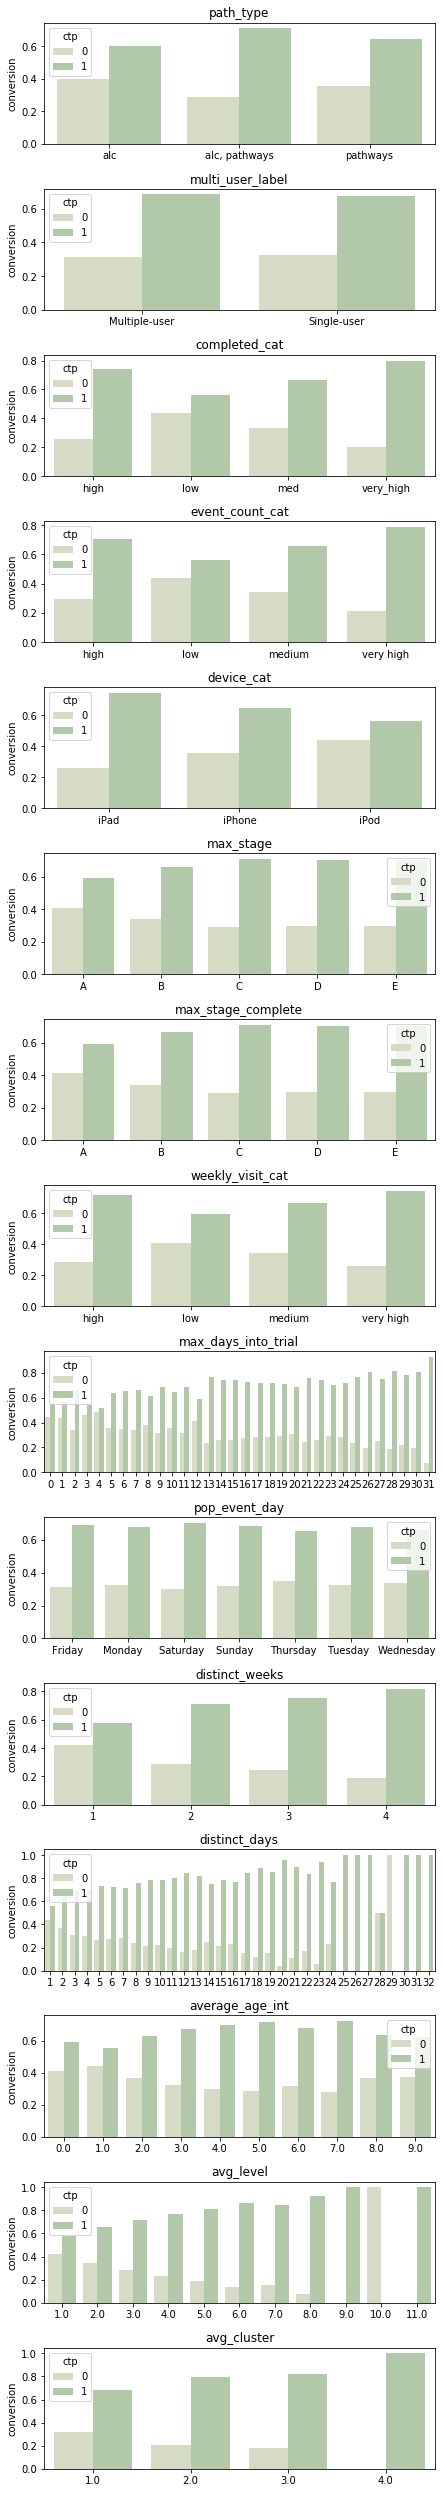

In [346]:
#visualize relationship to conversion rate for categorical variables
categorical_columns = ['path_type','multi_user_label','completed_cat','event_count_cat',
                      'device_cat','max_stage','max_stage_complete','weekly_visit_cat','max_days_into_trial','pop_event_day',
                      'distinct_weeks','distinct_days', 'average_age_int', 'avg_level','avg_cluster']

conversion_calc(homer, categorical_columns, plot = True)

#### Distributions to look at:
- total_events
- not_completed_count
- ipad_event
- iphone_event
- ipod_event
- avg_weekly_visit
- avg_daily_hrs
- max_row
- max_column
- avg_row
- avg_col
- max_days_into_trial

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


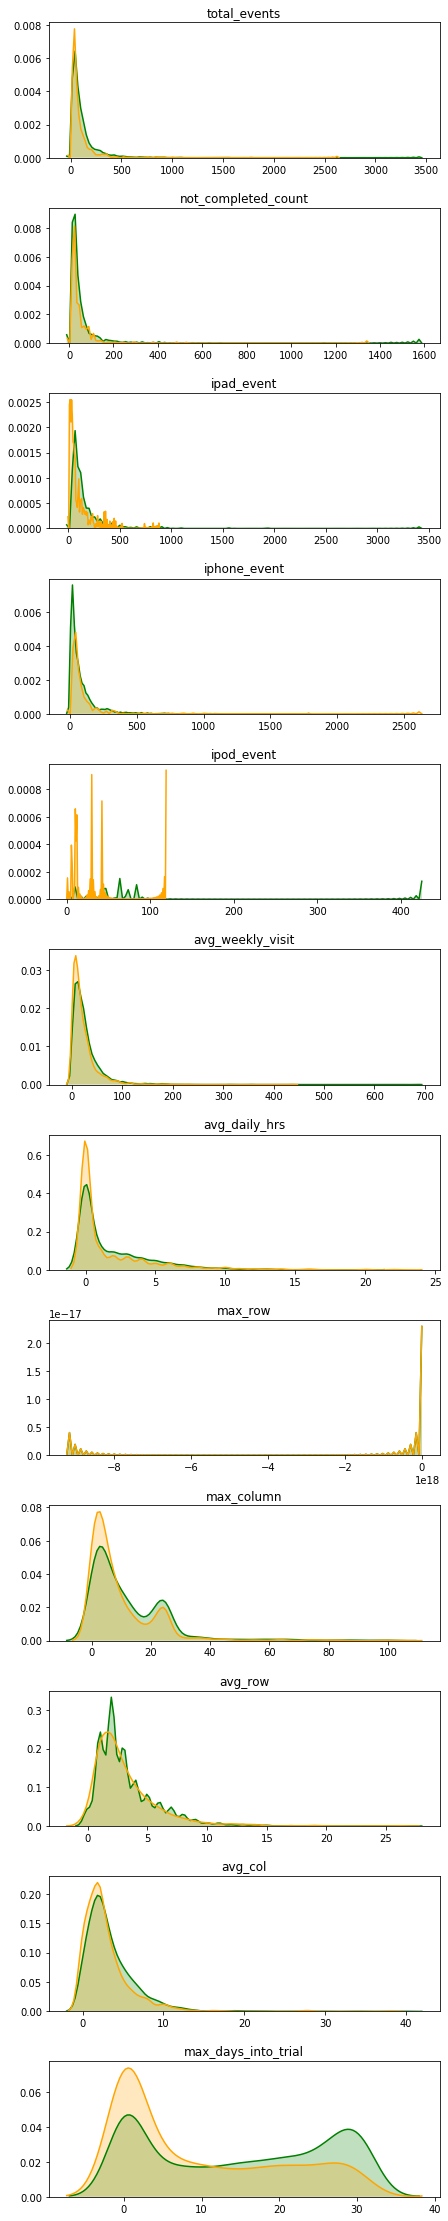

In [347]:
continuous_columns = ['total_events','not_completed_count','ipad_event','iphone_event','ipod_event','avg_weekly_visit',
                     'avg_daily_hrs','max_row','max_column','avg_row','avg_col','max_days_into_trial']

plot_continuous(homer, continuous_columns)

### 2. Data Preprocessing

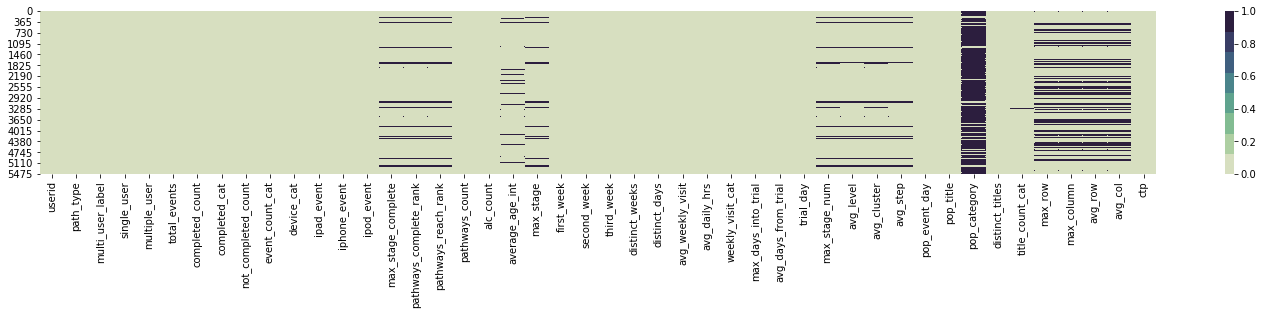

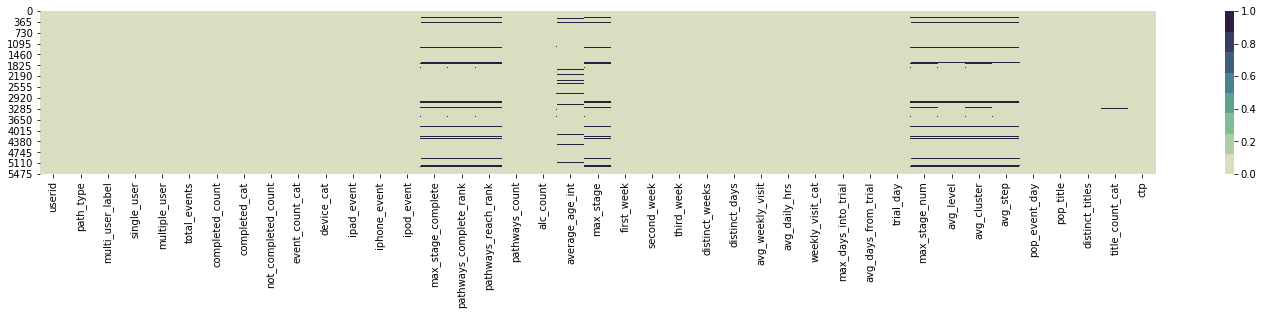

In [348]:
#display missing values before and after removing unecessary columns
plt.rcParams['figure.figsize'] = (25,3)
mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
sns.heatmap(homer.isnull(), cmap = mypalette)
plt.show()

#max_row, max_col, avg_row, avg_col don't seem to have strong correlation with CTP - delete
#pop_category is mostly missing - delete
homer_clean = homer.drop(['max_row','max_column','avg_row','avg_col','pop_category'],inplace = False, axis = 1)

sns.heatmap(homer_clean.isnull(), cmap = mypalette)
plt.show()

#for now, drop any rows with null values - revisit later
#can use knn imputation methods, since using average might not make sense
homer_nonull = homer_clean.dropna()

In [186]:
#pretending to remake supplementary columns - but really need the original dataset for this
orig_cols = ['userid','path_type','multi_user_label','total_events','completed_count','completed_cat','not_completed_count',
             'event_count_cat','device_cat','ipad_event','iphone_event','ipod_event','max_stage_complete',
             'pathways_complete_rank','pathways_reach_rank','pathways_count','alc_count','average_age_int','max_stage',
             'first_week','second_week','third_week','distinct_days','avg_weekly_visit','avg_daily_hrs','weekly_visit_cat',
             'max_days_into_trial','avg_days_from_trial','trial_day','max_stage_num','avg_level','avg_cluster','avg_step',
             'pop_event_day','pop_title','distinct_titles','title_count_cat', 'ctp']
new_cols = [column for column in homer_nonull.columns if column not in orig_cols]
new_cols

['single_user', 'multiple_user', 'distinct_weeks']

In [273]:
#look at conversion rates for top 20 titles
#75% of rows in dataset belong to top 20 titles
top20titles = homer_nonull['pop_title'].value_counts().nlargest(n=20).index
pop_titles = homer_nonull[homer_nonull['pop_title'].isin(top20titles)]
percent = pop_titles['pop_title'].value_counts().sum()/homer_nonull.shape[0]
print(f'percent of total records with top 20 title: {percent}')
print('top 20 titles are:')
for element in top20titles:
    print('  -'+element)
    
#create indicator columns for titles where the conversion is better than the baseline
title_conversions = conversion_calc(pop_titles, ['pop_title'], False)
best_titles = title_conversions[title_conversions['conversion'] > baseline]['pop_title'].to_list()

percent of total records with top 20 title: 0.7576819962878945
top 20 titles are:
  -Let's Draw
  -Letter Hunt
  -Make the Letters: A,a
  -What Comes Next?
  -What's That Sound?
  -Letter Trees: A,a
  -Letters and Sounds
  -New Letters and Sounds
  -Paint Pots: Colors
  -First Sound, Middle Sound
  -Teamwork!
  -Meet the Letter A
  -Memory Game: Friends
  -Power Practice
  -Memory Game: Zoo
  -Speed Read
  -Angelina: Our Favorite Time of Year is Spring
  -More Letters and Sounds
  -Sounds Abound
  -Same or Different


In [349]:
best_titles

['Angelina: Our Favorite Time of Year is Spring',
 "Let's Draw",
 'Memory Game: Friends',
 'Power Practice',
 'Same or Different',
 'Sounds Abound',
 'Speed Read',
 'Teamwork!',
 "What's That Sound?"]